In [2]:
%matplotlib inline
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D
from keras import optimizers, regularizers
from datetime import datetime
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import csv
np.random.seed(7)

Using TensorFlow backend.


### Define parameters

### Get Data
1. Coloumn 0 : height 
2. Coloumn 1 : Width
3. Coloumn 2 : P-wave velocity(V_p)    
4. Coloumn 3 : S- wave velocity (V_s)
5. Coloumn 4 : Ratio of V_p and V_s
6. Coloumn 5 : Thermal Energy 
7. Coloumn 6 : Depth(z)
8. Coloumn 7 : x coordinate
9. Coloumn 8 : Stress component xx
10. Coloumn 9 : Stress component xz
11. Coloumn 10 : Stress component zz
    
The data file has no any header and has 11 columns. The X can be first seven columns. We do not need x coordinate (8 column). This column can be ignored. Based on X we want to predict any of the stress components (xx/xz/zz).

In [3]:
no_of_layers = 2
input_layer = 7
output_layer = 2
learning_rate = 0.001
batch_size = 128
keep_prob = 1.0

In [4]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None)
df_val= pd.read_csv(val_file, sep=" ", header = None)
df_test= pd.read_csv(test_file, sep=" ", header = None)

coloumns =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'value']
df_train.columns = coloumns
df_val.columns = coloumns
df_test.columns = coloumns

df_train['new_col'] = df_train['syy']*df_train['mud']
df_val['new_col'] = df_val['syy']*df_val['mud']
df_test['new_col'] = df_test['syy']*df_test['mud']

df_train.head()

,height,width,sxx,sxy,syy,sdrop,mud,dc,value,new_col
0,0.103861,1.145663,-102.509086,58.619371,-117.766562,0.483821,0.216681,0.295842,0.0,-25.517776
1,0.088714,1.304360,-136.062270,51.391037,-126.715571,0.345944,0.447964,0.406466,1.0,-56.764014
2,0.099706,1.260377,-117.558936,40.972081,-115.529343,0.292719,0.501697,0.389360,1.0,-57.960725
3,0.115749,1.191782,-128.169036,94.020712,-157.830504,0.571710,0.202831,0.408976,0.0,-32.012919
4,0.017900,1.108150,-106.350320,29.148969,-101.379323,0.253122,0.324653,0.398592,1.0,-32.913101


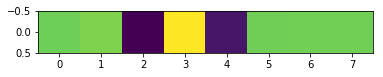

In [9]:
img_list = df_train.iloc[250, 0:8].values
img = np.reshape(img_list, (1, 8))
img
plt.figure()
plt.imshow(img)

In [5]:
from keras.utils import to_categorical

mms = StandardScaler()
X_train = mms.fit_transform(df_train.drop('value', axis=1))
Y_train = to_categorical(df_train['value'].values)

X_val = mms.fit_transform(df_val.drop('value', axis=1))
Y_val = to_categorical(df_val['value'].values)

X_test = mms.fit_transform(df_test.drop('value', axis=1))
Y_test = to_categorical(df_test['value'].values)

# print(X_train.shape)
# print(Y_test)

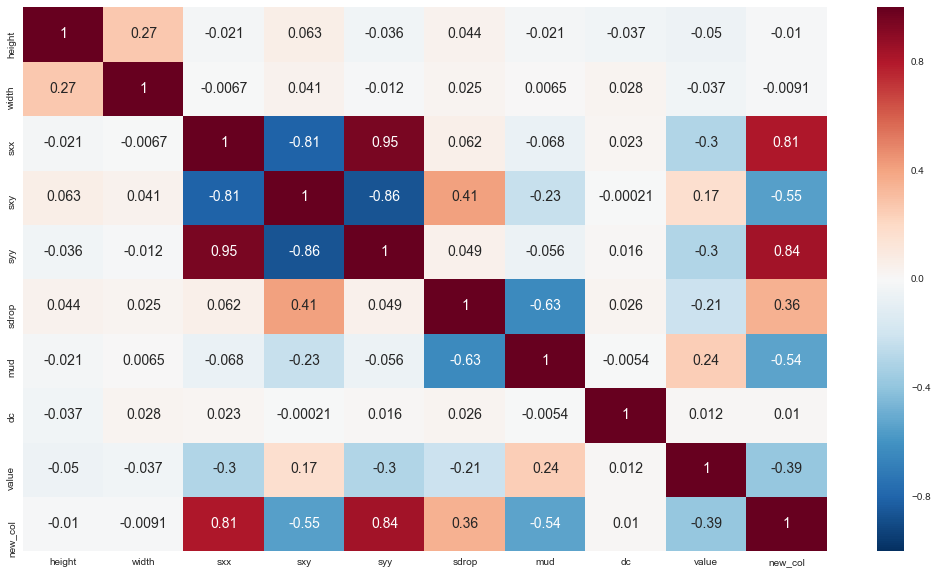

In [6]:
import seaborn as sns
plt.figure(figsize=(18, 10))
plt.rcParams.update({'font.size': 14})
sns.heatmap(df_train.corr(), annot = True)

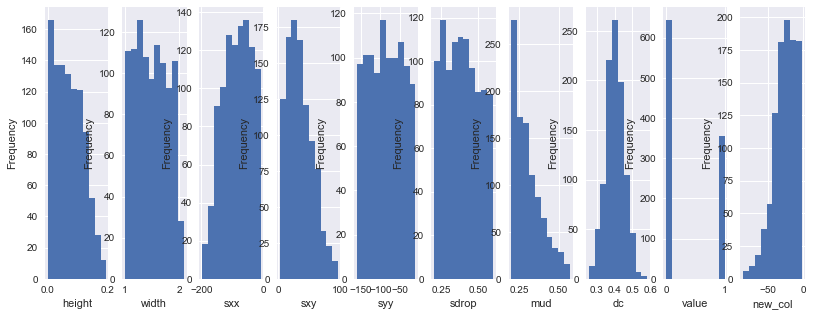

In [7]:
df_train.describe()
#plot Histogram

plt.figure(figsize=(15, 5))
for i, feature in enumerate(df_train.columns):
    plt.subplot(1, 11, i+1)
    df_train[feature].plot(kind='hist')
    plt.xlabel(feature)

In [8]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)
X_val, Y_val = shuffle(X_val, Y_val, random_state=0)
X_test, Y_test = shuffle(X_test, Y_test, random_state=0)


print(X_train.shape[1])
print(Y_train.shape)

9
(1000, 2)


### Model setup

In [46]:
def get_saved_model():
    loaded_model = load_model('./logs/rupture')
    loaded_model.load_weights('./logs/rupture_weights.epoch.499.hdf5')
    return loaded_model

def get_model(train_status):
    if train_status == 'new':   
        model = Sequential()
        model.add(Dense(units = 32, activation = 'relu', input_dim = X_train.shape[1], name='layer_1'))
        model.add(Dropout(0.3))
        model.add(Dense(units = 16, activation = 'relu', name='layer_2'))
        model.add(Dropout(0.3))
        model.add(Dense(units = Y_train.shape[1], activation="softmax", name='Output_layer'))
        model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        return model
    elif train_status == 'retrain':
        model = get_saved_model()
        model.compile('adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        return model
        

### Training

In [47]:
# Training
# now = datetime.now()
# path = './graph/' + 'stress'+ now.strftime("%Y%m%d-%H%M")+'_drop_' +\
#         str(keep_prob)+'_layer_'+ str(no_of_layers) +'_data_'+ str(no_of_data) +\
#         '_neuron_' + str(no_of_neurons)

training_epochs = 300
train_status = 'new' # retrain or new
model = get_model(train_status)
save_model(model, './logs/rupture')
checkpoint = ModelCheckpoint(filepath='./logs/rupture_weights.epoch.{epoch:02d}.hdf5', verbose=0)

# tbCallBack = TensorBoard(log_dir=path, histogram_freq=1, write_graph=True)

# history = model.fit(X_train, Y_train, epochs = training_epochs, batch_size=batch_size, verbose=1, 
#                     callbacks=[checkpoint], validation_data=(X_test, Y_test))

history = model.fit(X_train, Y_train, batch_size = 32, epochs = training_epochs, 
           validation_data=(X_val, Y_val), verbose=1, callbacks=[checkpoint])

score = model.evaluate(X_test, Y_test, batch_size=32)
print('Test score :', score)

Train on 1000 samples, validate on 600 samples
Epoch 1/300
1000/1000 [==============================] - 0s - loss: 0.6296 - acc: 0.6690 - val_loss: 0.5076 - val_acc: 0.8150
Epoch 2/300
1000/1000 [==============================] - 0s - loss: 0.6097 - acc: 0.6780 - val_loss: 0.4859 - val_acc: 0.8067
Epoch 3/300
1000/1000 [==============================] - 0s - loss: 0.6029 - acc: 0.6670 - val_loss: 0.4783 - val_acc: 0.8000
Epoch 4/300
1000/1000 [==============================] - 0s - loss: 0.6116 - acc: 0.6870 - val_loss: 0.4764 - val_acc: 0.8200
Epoch 5/300
1000/1000 [==============================] - 0s - loss: 0.5876 - acc: 0.6990 - val_loss: 0.4691 - val_acc: 0.8200
Epoch 6/300
1000/1000 [==============================] - 0s - loss: 0.5779 - acc: 0.6980 - val_loss: 0.4611 - val_acc: 0.8250
Epoch 7/300
1000/1000 [==============================] - 0s - loss: 0.5955 - acc: 0.7000 - val_loss: 0.4575 - val_acc: 0.8183
Epoch 8/300
1000/1000 [==============================] - 0s - loss: 0.5

1000/1000 [==============================] - 0s - loss: 0.5600 - acc: 0.7230 - val_loss: 0.4360 - val_acc: 0.8267
Epoch 130/300
1000/1000 [==============================] - 0s - loss: 0.5517 - acc: 0.7210 - val_loss: 0.4414 - val_acc: 0.8267
Epoch 131/300
1000/1000 [==============================] - 0s - loss: 0.5427 - acc: 0.7280 - val_loss: 0.4326 - val_acc: 0.8250
Epoch 132/300
1000/1000 [==============================] - 0s - loss: 0.5619 - acc: 0.7250 - val_loss: 0.4328 - val_acc: 0.8250
Epoch 133/300
1000/1000 [==============================] - 0s - loss: 0.5516 - acc: 0.7230 - val_loss: 0.4352 - val_acc: 0.8300
Epoch 134/300
1000/1000 [==============================] - 0s - loss: 0.5496 - acc: 0.7160 - val_loss: 0.4279 - val_acc: 0.8300
Epoch 135/300
1000/1000 [==============================] - 0s - loss: 0.5629 - acc: 0.7210 - val_loss: 0.4415 - val_acc: 0.8283
Epoch 136/300
1000/1000 [==============================] - 0s - loss: 0.5541 - acc: 0.7190 - val_loss: 0.4365 - val_ac

1000/1000 [==============================] - 0s - loss: 0.5414 - acc: 0.7260 - val_loss: 0.4359 - val_acc: 0.8233
Epoch 194/300
1000/1000 [==============================] - 0s - loss: 0.5401 - acc: 0.7210 - val_loss: 0.4378 - val_acc: 0.8200
Epoch 195/300
1000/1000 [==============================] - 0s - loss: 0.5399 - acc: 0.7310 - val_loss: 0.4318 - val_acc: 0.82170.731
Epoch 196/300
1000/1000 [==============================] - 0s - loss: 0.5377 - acc: 0.7210 - val_loss: 0.4317 - val_acc: 0.8267
Epoch 197/300
1000/1000 [==============================] - 0s - loss: 0.5412 - acc: 0.7340 - val_loss: 0.4396 - val_acc: 0.8283
Epoch 198/300
1000/1000 [==============================] - 0s - loss: 0.5437 - acc: 0.7240 - val_loss: 0.4368 - val_acc: 0.8233
Epoch 199/300
1000/1000 [==============================] - 0s - loss: 0.5407 - acc: 0.7260 - val_loss: 0.4392 - val_acc: 0.8200
Epoch 200/300
1000/1000 [==============================] - 0s - loss: 0.5388 - acc: 0.7330 - val_loss: 0.4366 - v

1000/1000 [==============================] - 0s - loss: 0.5451 - acc: 0.7340 - val_loss: 0.4275 - val_acc: 0.8300
Epoch 258/300
1000/1000 [==============================] - 0s - loss: 0.5412 - acc: 0.7290 - val_loss: 0.4308 - val_acc: 0.8267
Epoch 259/300
1000/1000 [==============================] - 0s - loss: 0.5338 - acc: 0.7270 - val_loss: 0.4314 - val_acc: 0.8267
Epoch 260/300
1000/1000 [==============================] - 0s - loss: 0.5253 - acc: 0.7390 - val_loss: 0.4271 - val_acc: 0.8250
Epoch 261/300
1000/1000 [==============================] - 0s - loss: 0.5252 - acc: 0.7290 - val_loss: 0.4264 - val_acc: 0.82330.751
Epoch 262/300
1000/1000 [==============================] - 0s - loss: 0.5248 - acc: 0.7360 - val_loss: 0.4289 - val_acc: 0.8233
Epoch 263/300
1000/1000 [==============================] - 0s - loss: 0.5220 - acc: 0.7460 - val_loss: 0.4293 - val_acc: 0.8233
Epoch 264/300
1000/1000 [==============================] - 0s - loss: 0.5277 - acc: 0.7380 - val_loss: 0.4333 - v

In [42]:
Y_pred = model.predict(X_test)
Y_test_class = np.argmax(Y_test, axis = 1)
y_pred_class = np.argmax(Y_pred, axis = 1)

In [43]:
# Benchmark
pd.Series(Y_test_class).value_counts()/len(Y_test_class)

0    0.68
1    0.32
dtype: float64

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(Y_test_class, y_pred_class))
print(classification_report(Y_test_class, y_pred_class))
confusion_matrix(Y_test_class, y_pred_class)

0.7475
             precision    recall  f1-score   support

          0       0.80      0.85      0.82       272
          1       0.62      0.54      0.58       128

avg / total       0.74      0.75      0.74       400



array([[230,  42],
       [ 59,  69]])

## Plot loss and accuracy 

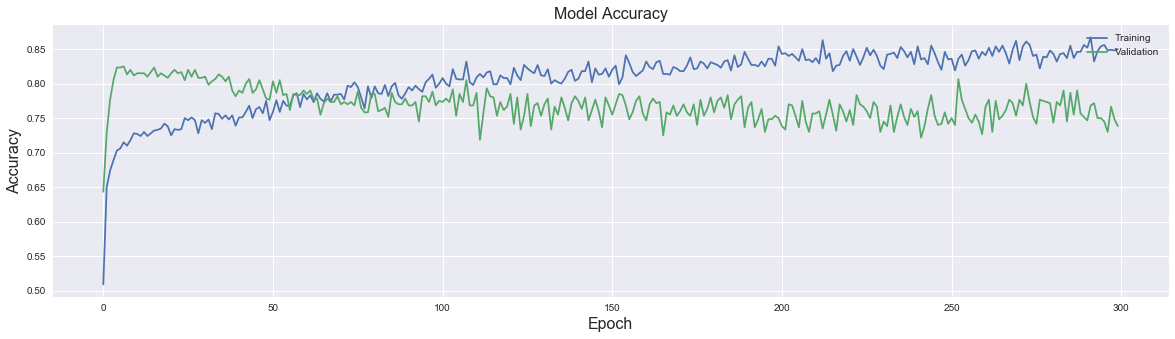

In [45]:
#print(history.history.keys())

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(20,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Training', 'Validation'], loc='upper right')


## Make prediction and visualize the prediction

In [11]:
# Restore trained model
loaded_model = load_model('./logs/stress')
loaded_model.load_weights('./logs/stress_weights.epoch.499.hdf5')
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 64)                512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
layer_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
layer_3 (Dense)              (None, 16)                528       
_________________________________________________________________
layer_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 9         
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


('RMS error : ', 1227.5785813141536)


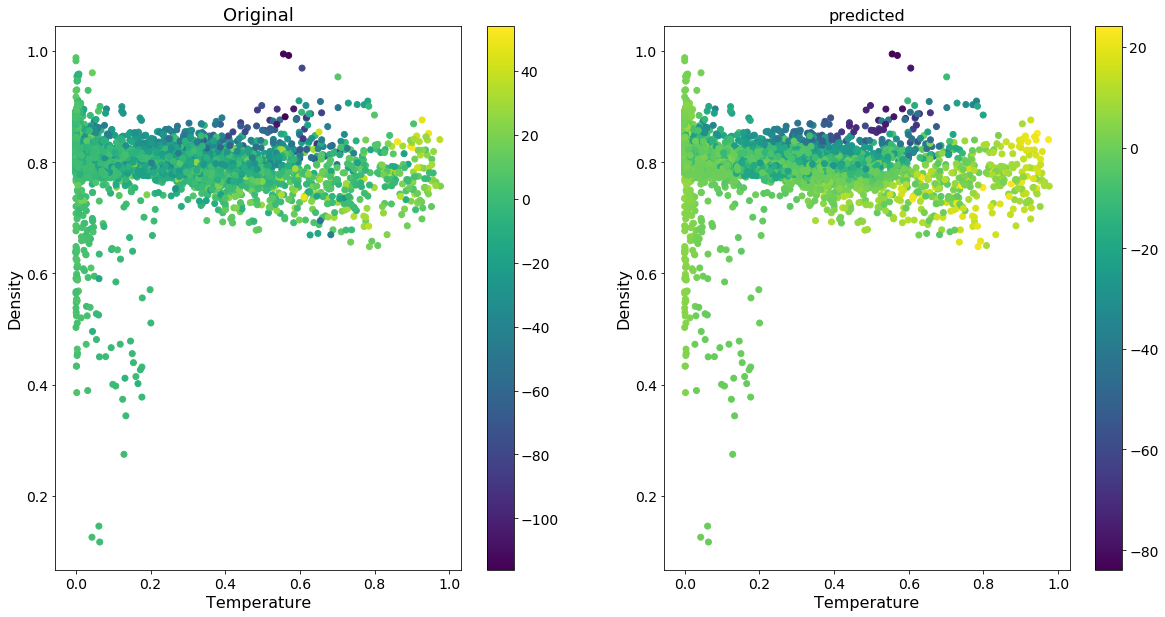

In [12]:
predicted = loaded_model.predict(X_test)

# transform to original unit
predicted = scaley.inverse_transform(predicted)
Y_test    = scaley.inverse_transform(Y_test)

# RMS error
error = np.sqrt(np.mean((predicted-Y_test)**2))
print("RMS error : ", error*100)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(X_test[:,0], X_test[:, 1], c=Y_test)
plt.title("Original", size=18)
plt.ylabel('Density', size=16)
plt.xlabel('Temperature', size=16)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], X_test[:, 1], c=predicted)
plt.title("predicted", size=16)
plt.ylabel('Density', size=16)
plt.xlabel('Temperature', size=16)
plt.colorbar()

plt.show()

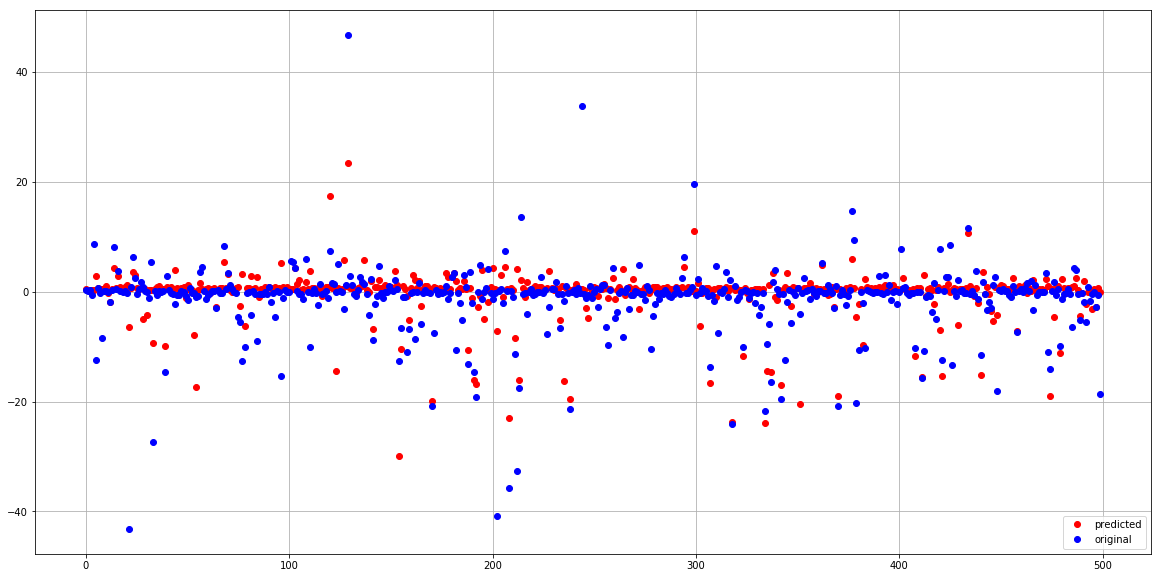

In [131]:
data = 500
plt.figure(figsize=(20,10))
plt.plot(predicted[:data], 'ro')
plt.plot(Y_test[:data], 'bo')
plt.legend(['predicted', 'original'], loc='lower right')
plt.grid()
plt.show()

## Restore model

In [68]:
# Evaluate with loaded model
evaluation = loaded_model.evaluate(X_test, Y_test, batch_size=10, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

7690/8000 [===========================>..] - ETA: 0s
Summary: Loss over the test dataset: 0.02, Accuracy: 0.00


## playinmg with the model

In [69]:
# "get_config()" returns a dictionary containing the configuration of the layer
# loaded_model.get_config()
# loaded_model.to_json()

#returns a list of all weight tensors in the model, as Numpy arrays
a = loaded_model.get_weights()
# print(a) # 10 layers
# print(a[2])

## Create image from weights

In [1]:
image = np.square(a[2].T)
plt.figure(figsize=(20,10))
plt.imshow(image, cmap=plt.cm.viridis, interpolation='nearest')
plt.colorbar()
plt.show()

NameError: name 'np' is not defined

In [ ]:
# from skimage import io, filters
# image = io.imread('download.jpg')
# # edges = filters.sobel(image)
# io.imshow(image)
# io.show()